In [1]:
import sys
import pandas as pd
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [9]:
j = janet.boot(uni, index=259)

In [10]:
j

Hi there! I'm Janet 🌵
I don't have any data or results in storage right now. Try running `janet.prepare_data()` to get started! ✨

In [11]:
j.prepare_data()

Making folder /Users/oliver hall/Research/unicorn/data/2227100384482274048/...
Found star in Sector(s) 17 18 24 25


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


In [12]:
period_range = (1, 12)
j.get_rotation()

### Running Simple Astropy Lomb-Scargle on Sector 17 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 18 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 18 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 24 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 24 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 25 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 25 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector all on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 2227100384482274048 ###
### Saved results ###
### Running Wavelet Est


### Completed Wavelet Estimation on star 2227100384482274048 ###
### Saved results ###


In [13]:
j

Hi there! I'm Janet 🌵

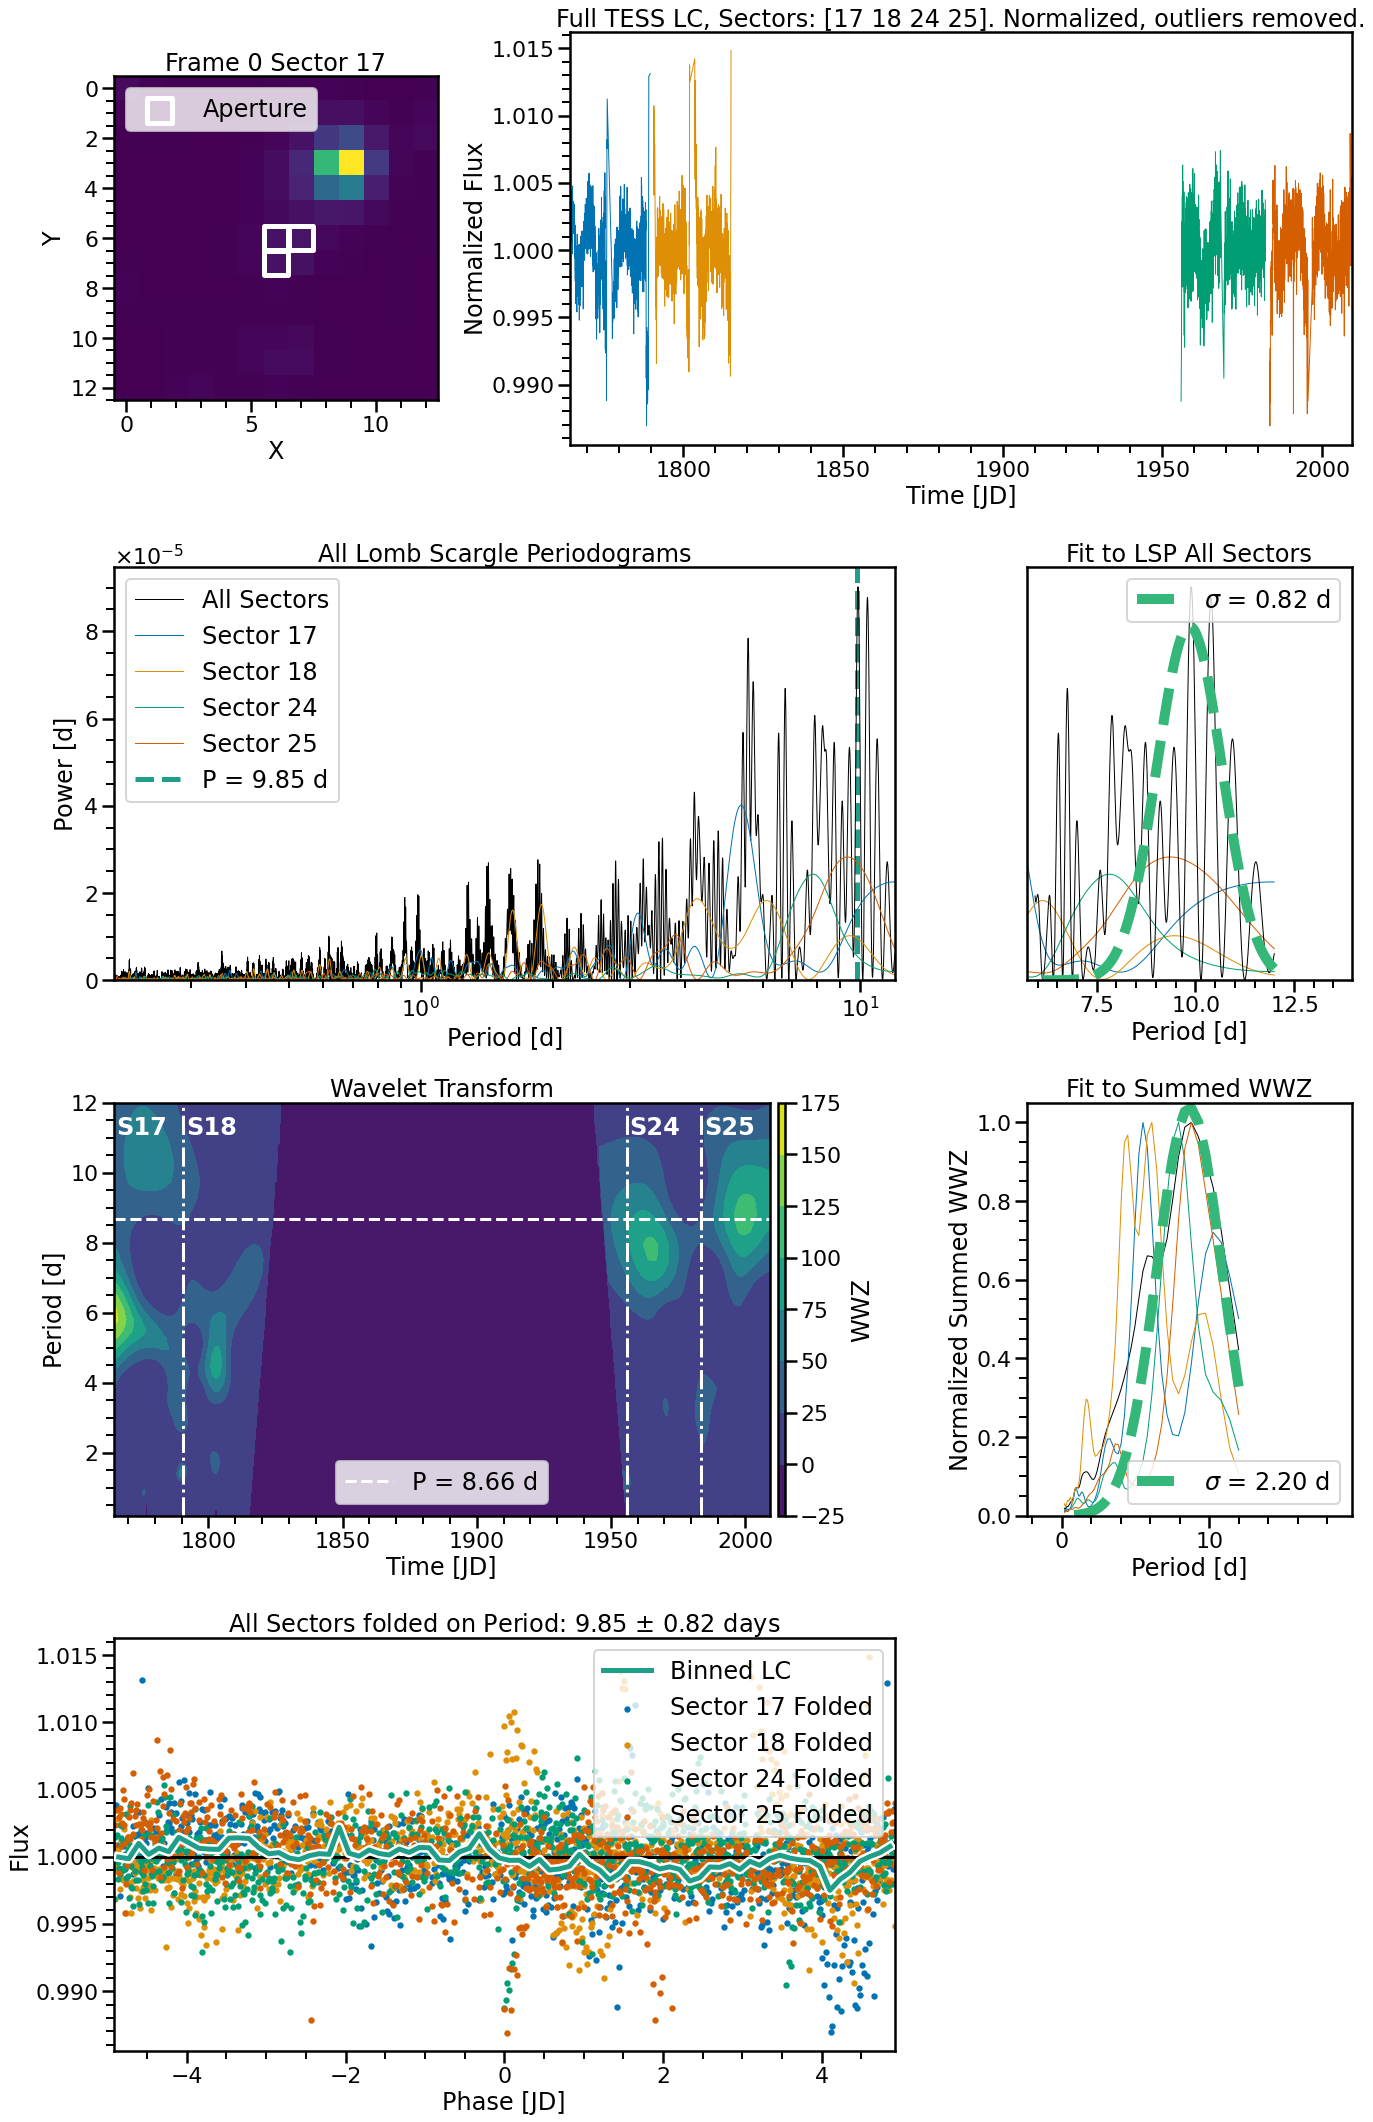

In [14]:
j.view()

- Improve period labels
- Add comparison plot at end
- Add consolidator
- Pickle the void

Text(0.5, 1.0, 'All Sectors folded on Period: 8.66 $\\pm$ 2.20 days')

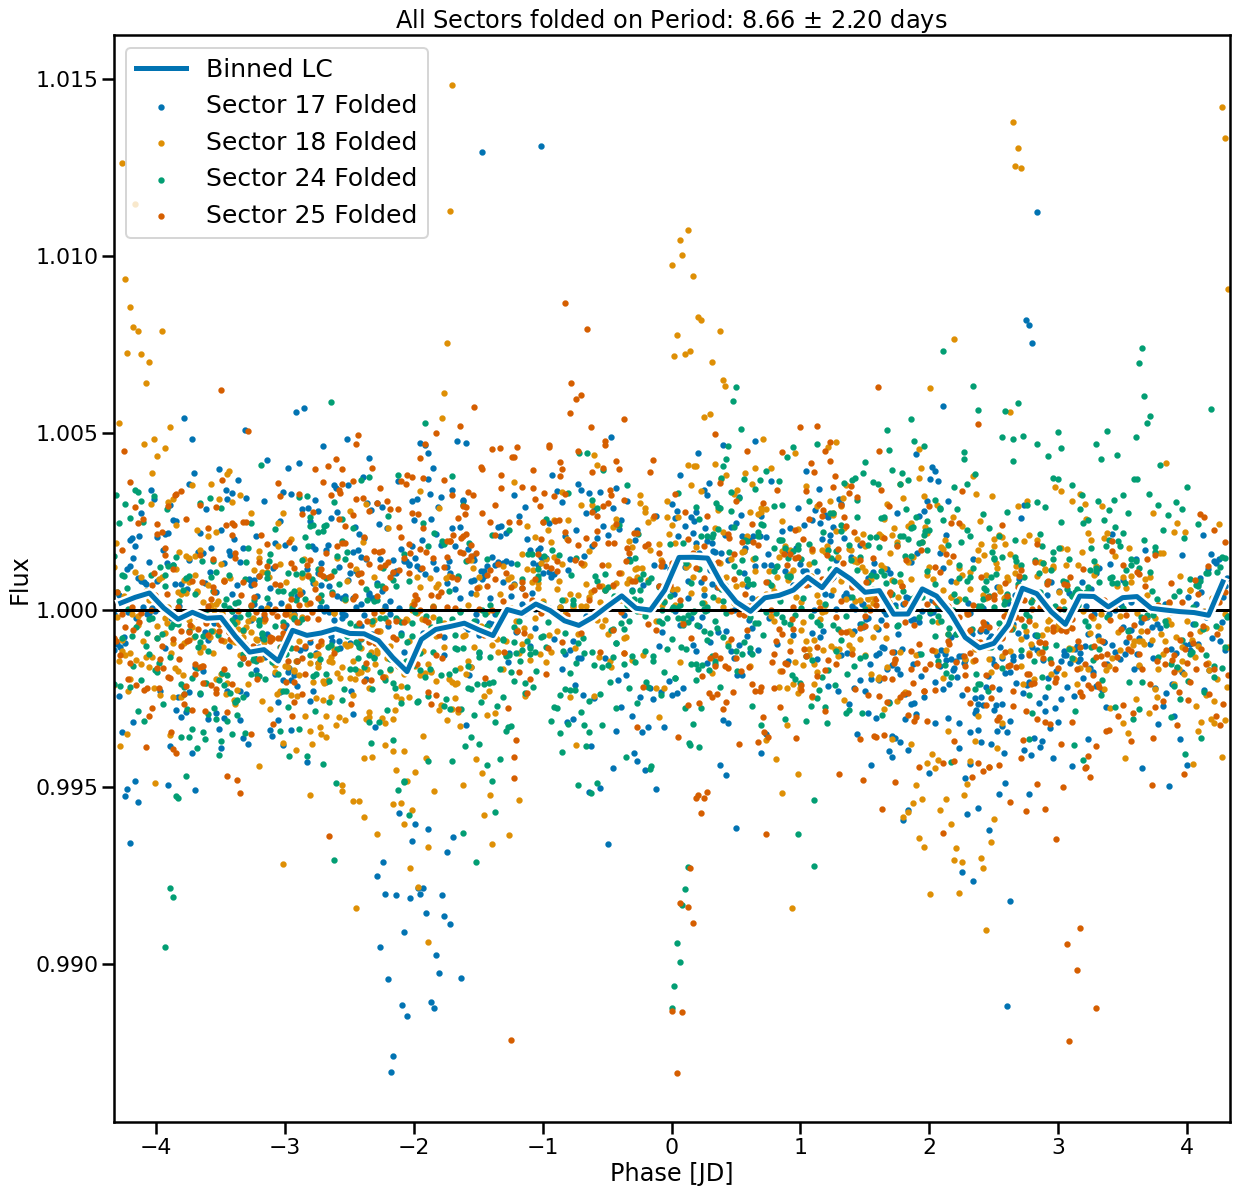

In [20]:
    import matplotlib.pyplot as plt
    fig, ax2 = plt.subplots(figsize=(20,20))
    fold = j.void['clc_all'].fold(period=j.results.loc['all', 'SW'])
    if len(j.sectors) >= 2:
        for s in j.sectors:
            j.void[f'clc_{s}'].fold(period=j.results.loc['all', 'SW']).scatter(s=75, label=f'Sector {s} Folded', ax=ax2, zorder=1)
    else:
        fold.scatter(ax=ax2, c='k', s=75, label='Folded LC', zorder=1)
    fold.bin(bins=int(len(fold)/50)).plot(ax=ax2, zorder=4, lw=5, label='Binned LC')
    fold.bin(bins=int(len(fold)/50)).plot(ax=ax2, zorder=3, lw=10, c='w')

    ax2.axhline(1., c='k', zorder=2, ls='-')
    ax2.set_xlim(fold.phase.min().value, fold.phase.max().value)
    ax2.legend(loc='best', fontsize=25)
    ax2.set_title(rf'All Sectors folded on Period: {j.results.loc["all", "SW"]:.2f} $\pm$ {j.results.loc["all", "e_SW"]:.2f} days')